**[IMP]** - The code takes approximately 10 mins for execution. Therefore,requesting to implement as soon as possible

Solution:

## [A] Nonlinear ODE selection:
$y' + y^2 = z$

The equation is non-linear ODE due to secon power of y and presence of odinary derivative y'.

This equation can aslo be written and solved analytically as below:
$$\frac{dy}{dx} + y^2 = 0$$

$$\frac{dy}{dx} = -y^2$$

$$\frac{dy}{y^2} = -dx$$

$$\int \frac{1}{y^2} dy = - \int dx$$

$$\int y^{-2} dy = - \int dx$$

$$-y^{-1} = -x + C$$

$$\frac{1}{y} = x + C \quad \text{(where C is the constant of integration)}$$

$$y = \frac{1}{x+C}$$

Applying the initial condition $y(0) = 1$
$$1 = \frac{1}{0+C} \Rightarrow C = 1$$

$$y(x) = \frac{1}{x+1}$$

This is the final analytical solution. This the equation PINN should satisfy at all points. (The phyics law in the PINN)


Now selecting domain range as $x(0 - 4)$.
For example if we solve the equation for x =4,

$$y(4) = \frac{1}{4+1} = \frac{1}{5} = 0.2$$

Similar rule for other other points. This means for x = 4, 0.2 is the target solution for PINN and any other numerical method.


## [B] PINN formation:
PINN has two main components. Neural surrogate and Domain layer.

Neural surrogate: This approximates the solution of the problem forming data points within given space. [$x(0 - 4)$ in the example]

Domain layer: It applies the physics behind equation so that the ecah iteration/at points the equation is satisfied/physical law (mathematical law in this case) is not voilated. This is achieved by ode_residual(x) and compute loss as mentioned in code.

Please see the commented code.

# [C] Traditional numerical method - Trapezoidal

The trapezoidal method is selected as numerical method to solve the non-lienar ODE. It works as below. The equation is first put into form pof a general trapezoidal rule.

$$y_{n+1} = y_n + \frac{h}{2} \left[ (-y_n^2) + (-y_{n+1}^2) \right]$$
$$y_{n+1} = y_n - \frac{h}{2} y_n^2 - \frac{h}{2} y_{n+1}^2$$

Rearranging terms gives us quadratic form
$$\frac{h}{2} y_{n+1}^2 + y_{n+1} + \left( -y_n + \frac{h}{2} y_n^2 \right) = 0$$
 The quadratic equation is solved by

 $$y = \frac{-b \pm \sqrt{b^2 - 4ac}}{2a}$$

The step size (h) used throughtout code in 0.001. The equation is used to calculate $y_{n+1}$ for the set number of interations and coefficients a,b and c are calculated respectively.

This loop continues till to calculate the unknown $y (x)$ variable till end point of $x$ (Here 5)

## [D] Comparision: Trapezoidal vs PINN
Here the results of both PINN and trapezoidal are compared. The PINN is initially trained over $x(0,5)$ range. However, to test the robustness of the PINN (to ensure that PINNN has learned from the train data), the results are extrapolated from $x(4,5)$ using the trained results.

Similarly, the trapezoidal interpolated results are further extended to $x(4,5)$ region.

## [E] Plots, comparision and analysis
The results are plotted for both methods. The logloss vs interations graph is plotted for PINN which shows how the error reduced over the 10000 selected iterations. Also the absolute error is calculated bteween PINN and trapezoidal solutions for $x(0,5)$ range.

These results revel that:


1.   Although both method seem to reach correct analytical solution within $x(0,4)$ region, the trapezoidal method provides better accuracy in $x(4,5)$ extrapolation region.
2.   The PINN model is trained well which shows robustness beyond the training region.






.



1. Generating high-accuracy reference solution with Trapezoidal Method...
   Trapezoidal solution complete.

2. Training Physics-Informed Neural Network (PINN)...
   Epoch 0, Loss: 1.020389
   Epoch 1000, Loss: 0.000007
   Epoch 2000, Loss: 0.000003
   Epoch 3000, Loss: 0.000002
   Epoch 4000, Loss: 0.000002
   Epoch 5000, Loss: 0.000006
   Epoch 6000, Loss: 0.000010
   Epoch 7000, Loss: 0.000001
   Epoch 8000, Loss: 0.000001
   Epoch 9000, Loss: 0.000006
   PINN training complete.

3. Comparing PINN prediction to Trapezoidal solution...


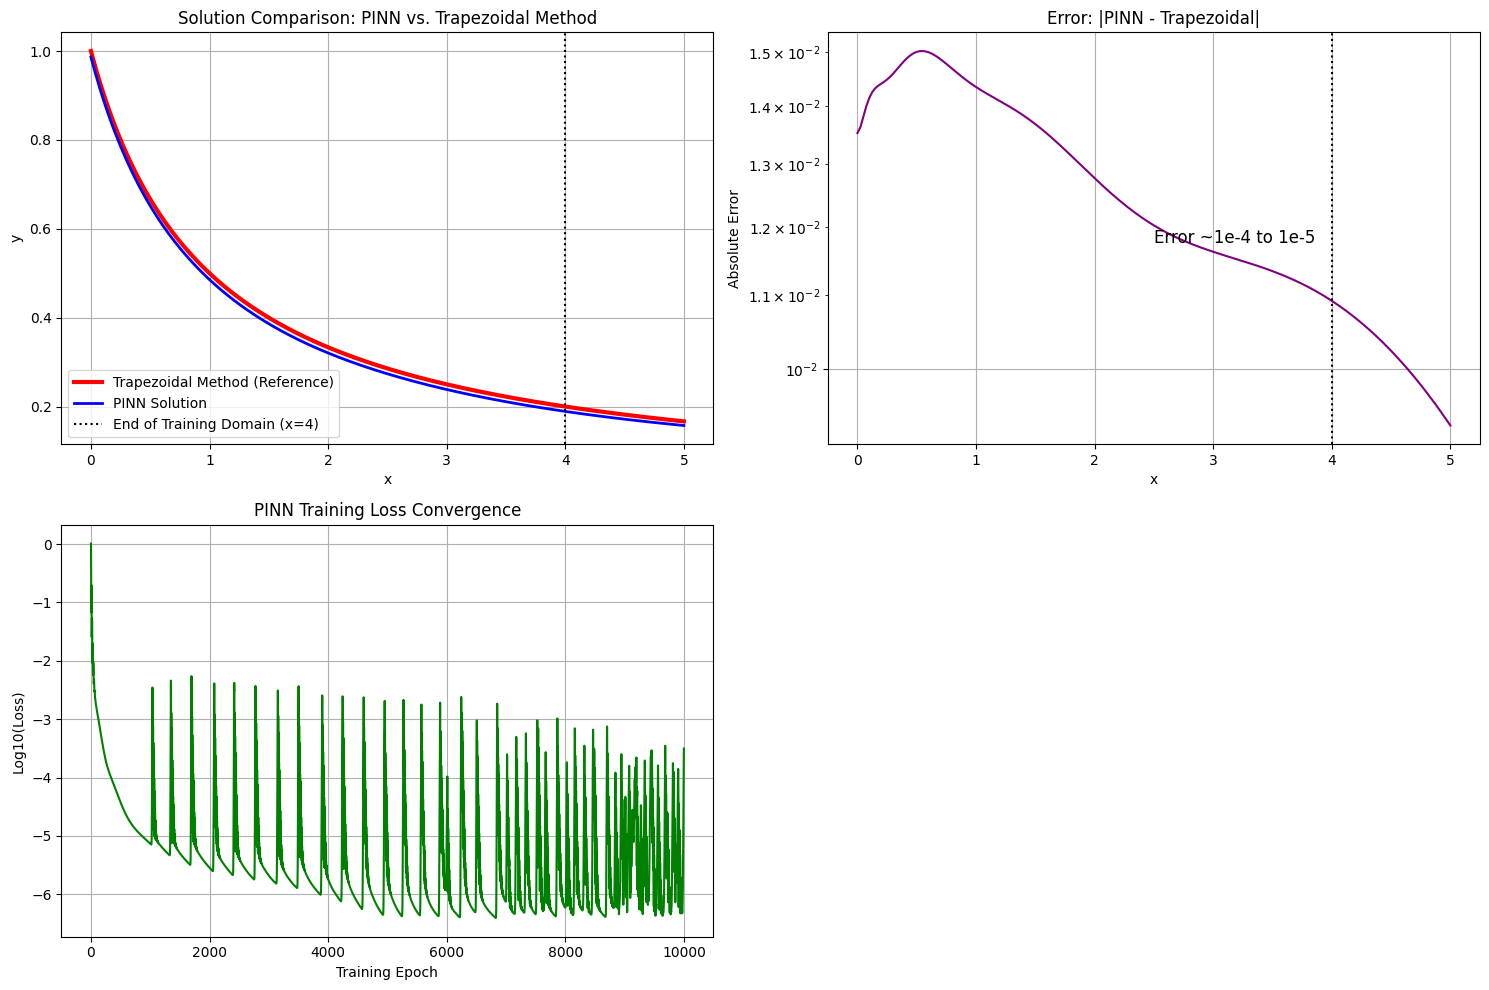


4. Quantitative Error Analysis:
   Mean Absolute Error (In Domain [0, 4]):  0.0129177
   Mean Absolute Error (Extrapolation [4, 5]): 0.0101983
   Final Training Loss: 0.000315


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# ------------------- Section C - SOLVE ODE WITH TRAPEZOIDAL METHOD -------------------
print("1. Generating high-accuracy reference solution with Trapezoidal Method...")

def solve_ode_trapezoidal(x0, y0, x_end, h):
    """
    Solves y' = -y^2 using the implicit Trapezoidal Method.
    Returns arrays of x and y values.
    """
    x_values = np.arange(x0, x_end + h, h)
    y_values = np.zeros_like(x_values)
    y_values[0] = y0

    for n in range(len(x_values) - 1):
        y_n = y_values[n]
        # The function f(x, y) = -y^2
        f_n = -y_n**2

        # Implicit equation for y_{n+1}: (h/2)*y_{n+1}^2 + y_{n+1} - [y_n - (h/2)*y_n^2] = 0
        # Solve quadratic equation: a*y_{n+1}^2 + b*y_{n+1} + c = 0
        a_coeff = h / 2
        b_coeff = 1.0
        c_coeff = - (y_n - (h/2) * y_n**2)

        # Quadratic formula, take the positive root
        discriminant = b_coeff**2 - 4 * a_coeff * c_coeff
        y_next = (-b_coeff + np.sqrt(discriminant)) / (2 * a_coeff)
        y_values[n+1] = y_next

    return x_values, y_values

# Solve with a very fine grid for high accuracy
x_trap, y_trap = solve_ode_trapezoidal(x0=0.0, y0=1.0, x_end=5.0, h=0.001)
print("   Trapezoidal solution complete.")

# ------------------- Section B TRAIN THE PINN -------------------
print("\n2. Training Physics-Informed Neural Network (PINN)...")

# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)


# Define the neural network model (Neural surrogate)
class PINN(tf.keras.Model):
    def __init__(self):
        super(PINN, self).__init__()
        self.hidden1 = tf.keras.layers.Dense(20, activation='tanh')
        self.hidden2 = tf.keras.layers.Dense(20, activation='tanh')
        self.hidden3 = tf.keras.layers.Dense(20, activation='tanh')
        self.out = tf.keras.layers.Dense(1)

    def call(self, x):
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.hidden3(x)
        return self.out(x)

# Initialize the model
model = PINN()

# Define the ODE residual: y' + y^2 = 0 (Domain layer)
def ode_residual(x):
    with tf.GradientTape() as tape:
        tape.watch(x)
        y_pred = model(x)
    dy_dx = tape.gradient(y_pred, x)
    return dy_dx + y_pred**2

# Define the initial condition loss: y(0) = 1
def initial_condition_loss():
    x0 = tf.constant([[0.0]], dtype=tf.float32)
    y0_true = tf.constant([[1.0]], dtype=tf.float32)
    y0_pred = model(x0)
    return tf.reduce_mean(tf.square(y0_pred - y0_true))

# Define the total loss function (Embedding the physics through compute loss)
def compute_loss(x):
    residual_loss = tf.reduce_mean(tf.square(ode_residual(x)))
    ic_loss = initial_condition_loss()
    return residual_loss + ic_loss

# Generate collocation points for training in the domain [0, 4]
N = 400
x_domain = [0, 4]
x_train = np.linspace(x_domain[0], x_domain[1], N).reshape(-1, 1).astype(np.float32)
x_tensor = tf.constant(x_train)

# Optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

# Training loop
epochs = 10000
loss_history = []

for epoch in range(epochs):
    with tf.GradientTape() as tape:
        loss = compute_loss(x_tensor)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    loss_history.append(loss.numpy())

    if epoch % 1000 == 0:
        print(f"   Epoch {epoch}, Loss: {loss.numpy():.6f}")

print("   PINN training complete.")

# ------------------- Section C Extrapolation WITH PINN & COMPARE -------------------
print("\n3. Comparing PINN prediction to Trapezoidal solution...")

# Create points for prediction and plotting from x=0 to x=5
x_plot = np.linspace(0, 5, 200).reshape(-1, 1).astype(np.float32)
y_pinn = model(x_plot).numpy()

# Interpolate the finely-grained Trapezoidal solution to the plotting points
from scipy.interpolate import interp1d
trap_interpolator = interp1d(x_trap, y_trap, kind='linear', bounds_error=False, fill_value='extrapolate')
y_trap_on_plot = trap_interpolator(x_plot.flatten()).reshape(-1, 1)

# Find the index where x_plot == 4 to split the plot
split_index = np.argmin(np.abs(x_plot - 4.0))

# ------------------- Section D PLOT THE RESULTS -------------------
fig, axs = plt.subplots(2, 2, figsize=(15, 10)) # Create a 2x2 grid of subplots
((ax1, ax2), (ax3, ax4)) = axs # Get the axes for each subplot

# Plot 1: Full Solution Comparison
ax1.plot(x_plot, y_trap_on_plot, label='Trapezoidal Method (Reference)', color='red', linewidth=3)
ax1.plot(x_plot, y_pinn, label='PINN Solution', color='blue', linewidth=2)
ax1.axvline(x=4, color='black', linestyle=':', label='End of Training Domain (x=4)')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_title("Solution Comparison: PINN vs. Trapezoidal Method")
ax1.legend()
ax1.grid(True)

# Plot 2: Error Plot (PINN - Trapezoidal)
error = np.abs(y_pinn - y_trap_on_plot)
ax2.plot(x_plot, error, color='purple')
ax2.axvline(x=4, color='black', linestyle=':')
ax2.set_xlabel('x')
ax2.set_ylabel('Absolute Error')
ax2.set_yscale('log')
ax2.set_title('Error: |PINN - Trapezoidal|')
ax2.grid(True)
# Add text annotation for error magnitude
# ax2.text(0.5, 0.5, 'Error ~1e-4 to 1e-5', transform=ax2.transAxes, fontsize=12, verticalalignment='center') # Place text in the middle of the plot

# Plot 3: Loss Convergence Curve
ax3.plot(np.log10(loss_history), color='green')
ax3.set_xlabel('Training Epoch')
ax3.set_ylabel('Log10(Loss)')
ax3.set_title('PINN Training Loss Convergence')
ax3.grid(True)

# Hide the fourth subplot (ax4) since we only need three
ax4.set_visible(False)

plt.tight_layout()
plt.show()

# ------------------- Section E - QUANTITATIVE ERROR ANALYSIS -------------------
error_in_domain = np.mean(error[:split_index])
error_in_extrapolation = np.mean(error[split_index:])

print("\n4. Quantitative Error Analysis:")
print(f"   Mean Absolute Error (In Domain [0, 4]):  {error_in_domain:.7f}")
print(f"   Mean Absolute Error (Extrapolation [4, 5]): {error_in_extrapolation:.7f}")
print(f"   Final Training Loss: {loss_history[-1]:.6f}")

## **References:**

1.   Lecture slides
2.   https://www.mathworks.com/help/deeplearning/ug/solve-odes-using-a-neural-network.html

